In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Video1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Video1/vapp.py
/content/drive/MyDrive/Video1/Copy_of_Assigment_Final.ipynb
/content/drive/MyDrive/Video1/my_trained_model.keras
/content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset/Meet and Split/Meet and Split (102).mp4
/content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset/Meet and Split/Meet and Split (100).mp4
/content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset/Meet and Split/Meet and Split (101).mp4
/content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset/Meet and Split/Meet and Split (10).mp4
/content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset/Meet and Split/Meet and Split (103).mp4
/content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset/Meet and Split/Meet and Split (1).mp4
/content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset/Meet and Split/Meet and Split (109).mp4
/content/drive/MyDrive/Video1/Human Activity Recognition - Vi

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, LSTM, Dense
from tensorflow.keras.utils import to_categorical


In [ ]:
# ==== 1. Setup ====
DATASET_PATH = '/content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset'
IMG_SIZE = 112
SEQUENCE_LENGTH = 20

In [ ]:
 #Check dataset structure to identify the location of videos
print("Exploring dataset structure...")
for root, dirs, files in os.walk(DATASET_PATH):
    print(f"DIR: {root}")
    for f in files:
        print("   FILE:", f)

Exploring dataset structure...
DIR: /content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset
DIR: /content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset/Meet and Split
   FILE: Meet and Split (102).mp4
   FILE: Meet and Split (100).mp4
   FILE: Meet and Split (101).mp4
   FILE: Meet and Split (10).mp4
   FILE: Meet and Split (103).mp4
   FILE: Meet and Split (1).mp4
   FILE: Meet and Split (109).mp4
   FILE: Meet and Split (11).mp4
   FILE: Meet and Split (107).mp4
   FILE: Meet and Split (104).mp4
   FILE: Meet and Split (105).mp4
   FILE: Meet and Split (108).mp4
   FILE: Meet and Split (106).mp4
   FILE: Meet and Split (110).mp4
   FILE: Meet and Split (112).mp4
   FILE: Meet and Split (114).mp4
   FILE: Meet and Split (113).mp4
   FILE: Meet and Split (111).mp4
   FILE: Meet and Split (12).mp4
   FILE: Meet and Split (118).mp4
   FILE: Meet and Split (119).mp4
   FILE: Meet and Split (115).mp4
   FILE: Meet and Split (117).mp4
   FILE: Meet and Spl

In [ ]:
# ==== 2. Define Video Loading Function ====
def load_video(path, max_frames=SEQUENCE_LENGTH):
    cap = cv2.VideoCapture(path)
    frames = []
    while len(frames) < max_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame = preprocess_input(frame.astype(np.float32))
        frames.append(frame)
    cap.release()
    while len(frames) < max_frames:
        frames.append(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32))  # Pad if necessary
    return np.array(frames)

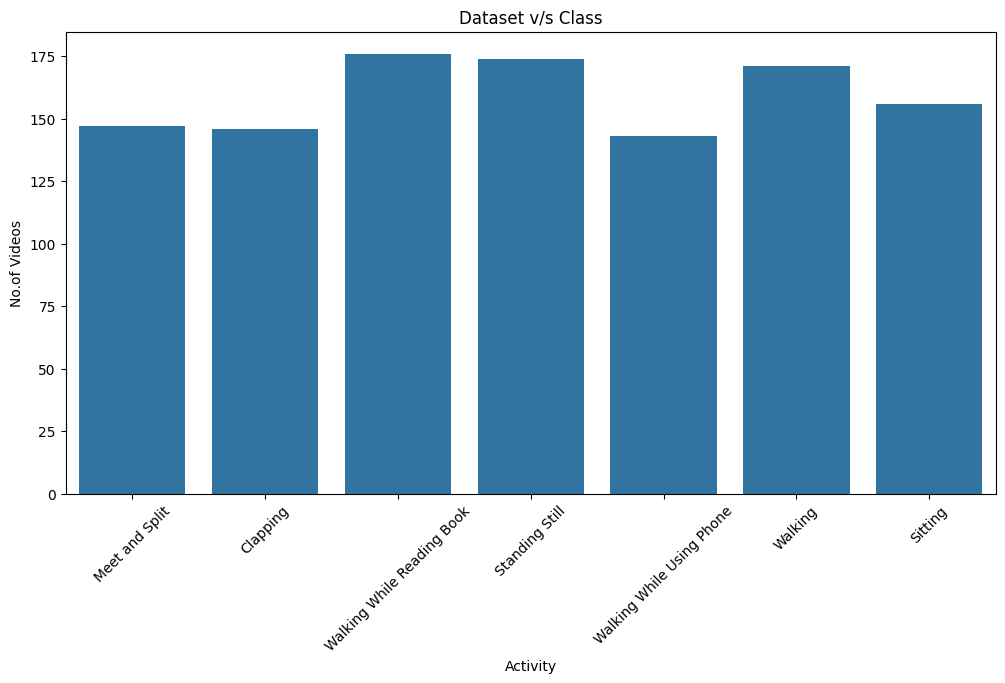

In [ ]:
#visulaising class distribution
import os
import seaborn as sns
import matplotlib.pyplot as plt

DATASET_PATH = '/content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset' # Make sure this path is correct

video_counts = {}
for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        video_counts[folder] = len(os.listdir(folder_path)) # Count number of videos in each folder


plt.figure(figsize=(12, 6))
sns.barplot(x=list(video_counts.keys()), y=list(video_counts.values()))
plt.xticks(rotation=45)
plt.xlabel("Activity")
plt.ylabel("No.of Videos")
plt.title("Dataset v/s Class")
plt.show()

In [ ]:
# ==== 3. Load Dataset (Update this step after directory inspection) ====
CLASSES_LIST = sorted([folder for folder in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, folder))])
print("Classes found:", CLASSES_LIST)

videos, labels = [], []
for class_label in CLASSES_LIST:
    # Update video path based on structure discovered from the previous output
    video_files = glob(os.path.join(DATASET_PATH, class_label, '*.mp4'))[:120]  # Adjust file extension if necessary
    print(f"Loading videos for class: {class_label}, found {len(video_files)} videos.")
    for video_path in video_files:
        video = load_video(video_path)
        if video.shape == (SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, 3):  # Ensure video is in expected shape
            videos.append(video)
            labels.append(class_label)

print(f"Total videos loaded: {len(videos)}")
if len(videos) == 0:
    raise ValueError("No videos were loaded. Please check the dataset structure.")

Classes found: ['Clapping', 'Meet and Split', 'Sitting', 'Standing Still', 'Walking', 'Walking While Reading Book', 'Walking While Using Phone']
Loading videos for class: Clapping, found 120 videos.
Loading videos for class: Meet and Split, found 120 videos.
Loading videos for class: Sitting, found 120 videos.
Loading videos for class: Standing Still, found 120 videos.
Loading videos for class: Walking, found 120 videos.
Loading videos for class: Walking While Reading Book, found 120 videos.
Loading videos for class: Walking While Using Phone, found 120 videos.
Total videos loaded: 840


In [ ]:
# Convert labels to categorical format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [ ]:

# ==== 4. Train-Test Split ====
X_train, X_test, y_train, y_test = train_test_split(videos, labels_categorical, test_size=0.2, random_state=42)

In [ ]:
# Reshape data to match the LSTM input requirements
X_train = np.array(X_train)
X_test = np.array(X_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (672, 20, 112, 112, 3)
X_test shape: (168, 20, 112, 112, 3)


In [ ]:
# ==== 5. Build CNN-LSTM Model ====
cnn_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
cnn_base.trainable = False  # Freeze CNN

model = Sequential([
    TimeDistributed(cnn_base, input_shape=(SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, 3)),
    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(64),
    Dense(128, activation='relu'),
    Dense(len(CLASSES_LIST), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

<ipython-input-13-39819defdc0f>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 4, 4, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       344,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,611,527 (9.96 MB)

 Trainable params: 353,543 (1.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ==== 6. Train Model ====
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=4)

Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 129s 341ms/step - accuracy: 0.2923 - loss: 1.7893 - val_accuracy: 0.6296 - val_loss: 1.1845
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - accuracy: 0.7557 - loss: 0.8533 - val_accuracy: 0.7704 - val_loss: 0.6885
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.9126 - loss: 0.3453 - val_accuracy: 0.8963 - val_loss: 0.3143
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9715 - loss: 0.1674 - val_accuracy: 0.9481 - val_loss: 0.1835
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9897 - loss: 0.0655 - val_accuracy: 0.9407 - val_loss: 0.1711
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 0.9795 - loss: 0.0749 - val_accuracy: 0.9481 - val_loss: 0.1074
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9750 - loss: 0.0682 - val_accuracy: 0.9556 - val_loss: 0.1004
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.9971 - loss: 

In [ ]:
# ==== 7. Evaluate Model ====
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step

Classification Report:

                            precision    recall  f1-score   support

                  Clapping       1.00      1.00      1.00        29
            Meet and Split       0.89      0.84      0.86        19
                   Sitting       1.00      1.00      1.00        27
            Standing Still       0.96      0.92      0.94        25
                   Walking       0.84      0.84      0.84        19
Walking While Reading Book       1.00      0.96      0.98        23
 Walking While Using Phone       0.90      1.00      0.95        26

                  accuracy                           0.95       168
                 macro avg       0.94      0.94      0.94       168
              weighted avg       0.95      0.95      0.95       168



In [ ]:
# Test accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=4)
print(f"Test accuracy: {test_accuracy:.4f}")


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9288 - loss: 0.2176
Test accuracy: 0.9464


In [ ]:
# Predict test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print("\nClassification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step

Classification Report:

                            precision    recall  f1-score   support

                  Clapping       1.00      1.00      1.00        29
            Meet and Split       0.89      0.84      0.86        19
                   Sitting       1.00      1.00      1.00        27
            Standing Still       0.96      0.92      0.94        25
                   Walking       0.84      0.84      0.84        19
Walking While Reading Book       1.00      0.96      0.98        23
 Walking While Using Phone       0.90      1.00      0.95        26

                  accuracy                           0.95       168
                 macro avg       0.94      0.94      0.94       168
              weighted avg       0.95      0.95      0.95       168



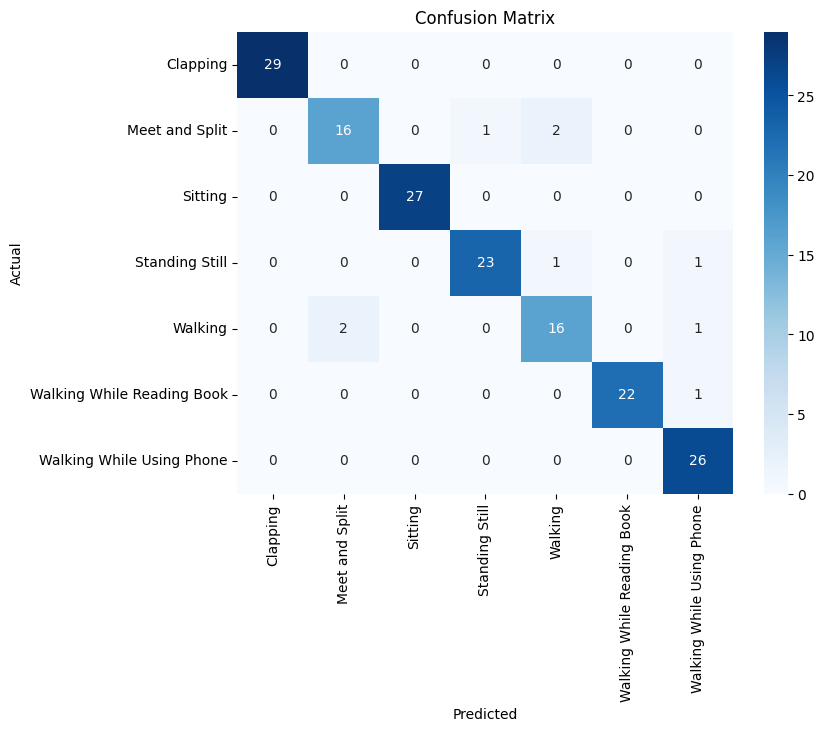

In [ ]:
# ==== 8. Confusion Matrix ====
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# ==== 9. Predict One Frame from Test Data ====
# Predict the class of the first frame of each video
frame_predictions = []
for video in X_test:
    frame = np.expand_dims(video[0], axis=0)  # Take the first frame
    frame_prediction = model.predict(np.expand_dims(frame, axis=0))
    predicted_class = label_encoder.inverse_transform([np.argmax(frame_prediction)])
    frame_predictions.append(predicted_class[0])

print("Predictions for the first frame of each test video:")
for i, pred in enumerate(frame_predictions[:10]):  # Show the first 10 predictions
    print(f"Video {i+1}: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

In [ ]:
def predict_video(model, video_path):
    # Load the video
    video = load_video(video_path)

    # Predict using the model (this will predict over the entire sequence)
    prediction = model.predict(np.expand_dims(video, axis=0))  # Add batch dimension
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])

    return predicted_class[0]

# Example usage for a video:
video_path = "/content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset/Clapping/Clapping (1).mp4"  # Path to the video file
predicted_class = predict_video(model, video_path)
print(f"Predicted class for the video: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Predicted class for the video: Clapping


In [ ]:
def predict_video(model, video_path):
    # Load the video
    video = load_video(video_path)

    # Predict using the model (this will predict over the entire sequence)
    prediction = model.predict(np.expand_dims(video, axis=0))  # Add batch dimension
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])

    return predicted_class[0]

# Example usage for a video:
video_path = "/content/drive/MyDrive/Video1/Human Activity Recognition - Video Dataset/Meet and Split/Meet and Split (1).mp4"  # Path to the video file
predicted_class = predict_video(model, video_path)
print(f"Predicted class for the video: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted class for the video: Meet and Split


In [ ]:
# Assuming 'model' is your trained Keras model

# Specify the path where you want to save the model
model_save_path = '/content/drive/MyDrive/Video1/my_trained_model.keras'

# Save the model
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Video1/my_trained_model.keras


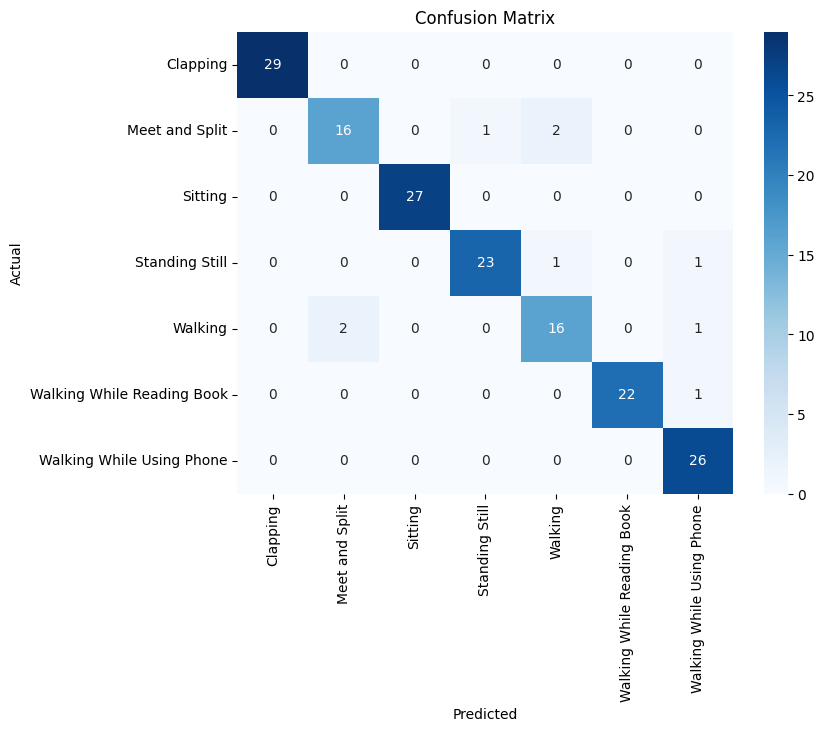

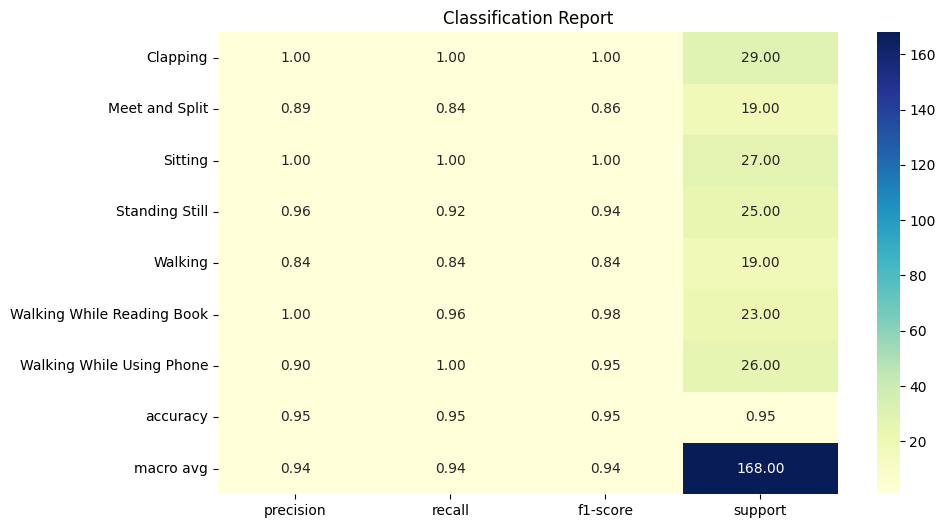

In [ ]:
# prompt: print confusion matrix all and realted plots

import pandas as pd
# Assuming 'y_true_labels' and 'y_pred_labels' are already defined

# ==== 8. Confusion Matrix and related plots ====
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Classification Report (already printed above, but adding plot for completeness)
report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Classification Report")
plt.show()
